# Comparison to other photometric fits

What do we observe if we compare our optimized models to that obtained by Sandor (we'll throw an assertion error here if we don't have a closer than 1 arcsecond match between our galaxy and anything in his catalog)


TODO: make this a hell of a lot more readable

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import json
import pickle
import pandas as pd
from copy import deepcopy
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from multiprocessing import Pool
import lib.galaxy_utilities as gu
import lib.python_model_renderer.render_galaxy as rg
import lib.python_model_renderer.parse_annotation as pa
from best_individual_classifications import get_best_classification
from model_fitting import Model, ModelFitter

In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
SHOULD_RECALCULATE = False

# only use if you won't interrupt mid-process, as interrupting will cause problems
SHOULD_MULTIPROCESS = True

In [5]:
with open('lib/best-classifications.json') as f:
    best_cls = json.load(f)

In [6]:
to_iter = pd.read_csv('lib/subject-id-list.csv').values[:, 0]

In [7]:
sd = pd.read_csv('lib/Kruk2018_Table2_Table3.csv')
coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)
s_keys = [
  'ra', 'dec', 'Fit_components',
  'r_disc', 're_disc', 'ba_disc',
  'r_bulge', 're_bulge', 'ba_bulge', 'n_bulge',
  'r_bar', 're_bar', 'ba_bar', 'n_bar',
]

In [8]:
def make_dfs(m, s, pxs=1):
    c, _ = m.to_df()
    gzb_comps = '+'.join(
        i for i, j in zip(
            ('disc', 'bar', 'bulge'),
            ~np.isnan(c['axRatio'].values)
        ) if j
    )
    c['rEff'] *= pxs / 2
    gzb_data = pd.Series([
        np.nan, np.nan, gzb_comps,
        *c.loc['disk'][['i0', 'rEff', 'axRatio']],
        *c.loc['bulge'][['i0', 'rEff', 'axRatio', 'n']],
        *c.loc['bar'][['i0', 'rEff', 'axRatio', 'n']],
    ], index=s_keys, name='GZB')
    return pd.concat((s[s_keys].rename('Sandor_fit'), gzb_data), axis=1, sort=False)

In [9]:
def get_optimized_model(subject_id):
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    sep = coords.separation(SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree))
    idxmin_sep = np.argmin(sep)
    if not sep[idxmin_sep] < 1 * u.arcsec:
        return None
    pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
    psf = gu.get_psf(subject_id)
    diff_data = gu.get_image_data(subject_id)
    pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
    galaxy_data = np.array(diff_data['imageData'])[::-1]
    size_diff = diff_data['width'] / diff_data['imageWidth']
    # arcseconds per pixel for zooniverse image
    pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
    # arcseconds per pixel for galaxy data
    pix_size2 = galaxy_data.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
    try:
        c = gu.classifications.query(
            'classification_id == {}'.format(
                best_cls[str(subject_id)]
            )
        ).iloc[0]
    except KeyError:
        print('Failed: {}'.format(subject_id))
        return None
    a = json.loads(c['annotations'])
    model = pa.parse_annotation(a, size_diff=size_diff)

    no_spiral_model = deepcopy(model)
    no_spiral_model['spiral'] = []

    mf_nosp = ModelFitter(no_spiral_model, galaxy_data, psf, pixel_mask)
    md_nosp = mf_nosp.model

    new_nosp_model, res = mf_nosp.fit(options={'maxiter': 100})
    m0_nosp = Model(no_spiral_model, galaxy_data, psf, pixel_mask)
    m1_nosp = Model(new_nosp_model, galaxy_data, psf, pixel_mask)
    return (subject_id, m0_nosp, m1_nosp, sd.iloc[idxmin_sep], pix_size2)

In [10]:
if SHOULD_RECALCULATE:
    if SHOULD_MULTIPROCESS:
        p = Pool(4)
        try:
            out = p.map(get_optimized_model, to_iter)
        except KeyboardInterrupt as e:
            p.terminate()
            raise e
        p.close()
    else:
        out = [get_optimized_model(subject_id) for subject_id in to_iter]
    out = [i for i in out if i is not None]
    sids = [i[0] for i in out]
    out2 = list(map(lambda o: make_dfs(o[2], o[3]), out))
    with open('sandor-comparisons.pickle', 'wb') as f:
        pickle.dump([sids, out2], f)
else:
    with open('sandor-comparisons.pickle', 'rb') as f:
        sids, out2 = pickle.load(f)

In [11]:
df_ba_disc = pd.concat([
    df.loc['ba_disc'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['ba_disc'].values == 0)
], axis=1, sort=False).transpose()

df_ba_bulge = pd.concat([
    df.loc['ba_bulge'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['ba_bulge'].values == 0)
], axis=1, sort=False).transpose()

df_ba_bar = pd.concat([
    df.loc['ba_bar'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['ba_bar'].values == 0)
], axis=1, sort=False).transpose()

In [12]:
df_re_disc = pd.concat([
    df.loc['re_disc'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['re_disc'].values == 0)
], axis=1, sort=False).transpose()

df_re_bulge = pd.concat([
    df.loc['re_bulge'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['re_bulge'].values == 0)
], axis=1, sort=False).transpose()

df_re_bar = pd.concat([
    df.loc['re_bar'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['re_bar'].values == 0)
], axis=1, sort=False).transpose()

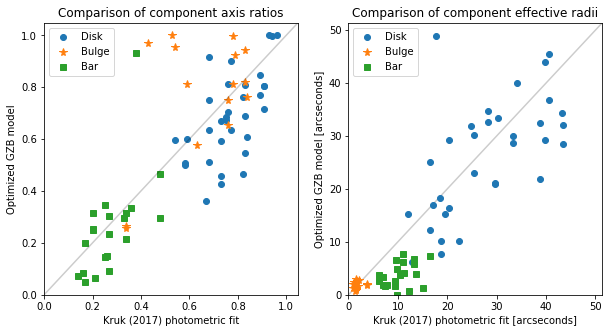

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(*df_ba_disc.values.T, 'o', markersize=6, label='Disk')
plt.plot(*df_ba_bulge.values.T, '*', markersize=8, label='Bulge')
plt.plot(*df_ba_bar.values.T, 's', label='Bar')
plt.legend()
plt.title('Comparison of component axis ratios')
plt.xlabel('Kruk (2017) photometric fit')
plt.ylabel('Optimized GZB model')
l = np.stack((plt.xlim(), plt.ylim())).max()
plt.plot([0, l], [0, l], 'k', alpha=0.2)
plt.xlim(0, l)
plt.ylim(0, l)

plt.subplot(122)
plt.plot(
    *df_re_disc.dropna().values.T,
    'o', markersize=6, label='Disk'
)
plt.plot(
    *df_re_bulge.dropna().values.T,
    '*', markersize=8, label='Bulge'
)
plt.plot(
    *df_re_bar.dropna().values.T,
    's', label='Bar'
)
plt.legend()
plt.title('Comparison of component effective radii')
plt.xlabel('Kruk (2017) photometric fit [arcseconds]')
plt.ylabel('Optimized GZB model [arcseconds]')
# plt.ylabel('Optimized GZB model')
l = np.stack((plt.xlim(), plt.ylim())).max()
plt.plot([0, l], [0, l], 'k', alpha=0.2, zorder=0)
plt.xlim(0, l)
plt.ylim(0, l)
plt.savefig('method-paper-plots/sd_comp_comparison.pdf', bbox_inches='tight');

In [14]:
bb = np.array(['bar' in o.loc['Fit_components']['GZB'] for o in out2 if 'bar' in o.loc['Fit_components']['Sandor_fit']])
print('Fraction of GZB models with bar: {}/{}'.format(bb.sum(), len(bb)))

Fraction of GZB models with bar: 30/33


In [21]:
display(df_re_disc.query('GZB > 45'))
out2[sids == 21096935]

,Sandor_fit,GZB
20902043,40.54,45.5584
21096935,17.68,48.9241


,Sandor_fit,GZB
ra,170.444,NaN
dec,25.9716,NaN
Fit_components,disc+bar+bulge,disc+bar
r_disc,15.48,0.179528
re_disc,29.71,20.9569
ba_disc,0.58,0.499636
r_bulge,19.17,0.487548
re_bulge,3.7,1.96008
ba_bulge,0.34,0.258618
n_bulge,0.55,0.674174
